**Atividade - Treinamento eInferência de Dados**

<br>

**Nomes e RGMs:**

Gabriela Cristina Schmitt   - RGM 25733150, 
Jennifer Mayara de Paiva Goberski, 25810723

In [ ]:
!pip install pandas==1.5.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

from sklearn import preprocessing
import pickle 
import pandas as pd 
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import math

def load_new_df(path): 
  try:
    dados = pd.read_csv(path, sep = ',')
    dados = dados.drop(columns = ['SpeciesName', 'SpeciesID', 'DNAtype'])
    return dados
  except:
    raise ValueError("Unable to load data from file: " + path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class Normalizer:
  def __init__(self, normalizer=None):
    self.data = None
    self.Norm_num = None
    self.Norm_cat = None
    self.NormData = None
    self.dummy_separator = '&'
    self.NormResultDf = None
    if normalizer is not None:
      self.normalizer = normalizer
    else:
      self.normalizer = None

   
  def __process_value(self, value):
    if type(value) == str:
        return value.replace(',', '.')
    else:
        return value 


  def __format_numeric_data(self):
    dados = self.data
    dados_num = dados.drop(columns = ['Kingdom'])

    for column in dados_num.columns:
      dados_num[column] = dados_num[column].apply(self.__process_value)

    dados_num = dados_num.applymap(lambda x: float(x) if isinstance(x, str) else x)
    return dados_num


  def __get_normalized_numDF(self):
      if self.data is None: 
        raise ValueError("No data loaded yet. Please call load_data() first.")
      else: 
        print('\n --------NORMALIZANDO DADOS NUMÉRICOS--------\n')
        dados_num = self.__format_numeric_data()

        normalizador = preprocessing.MinMaxScaler()
        modelo_normalizador = normalizador.fit(dados_num) 
  
        dados_num_normalizado = modelo_normalizador.fit_transform(dados_num)   
        self.Norm_num = pd.DataFrame(dados_num_normalizado, columns = dados_num.columns)
        pickle.dump(modelo_normalizador, open('/content/drive/MyDrive/Sistemas Inteligentes Avancados/normalizer_dna.model', 'wb'))
        self.normalizer = pickle.load(open('/content/drive/MyDrive/Sistemas Inteligentes Avancados/normalizer_dna.model', 'rb')) 
  

  def __get_normalized_catDF(self, action):
      if self.data is None: 
        raise ValueError("No data loaded yet. Please call load_data() first.")

      else: 
        print('\n --------NORMALIZANDO DADOS CATEGÓRICOS--------\n')
        numeric_cols = list(self.Norm_num.columns) 

        dados_cat = self.data.drop(columns=numeric_cols)
        dados_cat_normalizado = pd.get_dummies(dados_cat, prefix_sep=self.dummy_separator) 
        
        self.Norm_cat = dados_cat_normalizado

        if action == 1: # train
          pickle.dump(self.Norm_cat.columns, open('/content/drive/MyDrive/Sistemas Inteligentes Avancados/Norm_cat_columns.model', 'wb'))
        elif action == 2: # inference
          model_columns = pickle.load(open('/content/drive/MyDrive/Sistemas Inteligentes Avancados/Norm_cat_columns.model', 'rb'))
          model_columns_df = pd.DataFrame(columns=model_columns)

          common_col = set(self.Norm_cat.columns).intersection(set(model_columns_df.columns))
          common_col = list(common_col)

          self.Norm_cat = pd.merge(self.Norm_cat, model_columns_df, on=common_col[0], how='left')
          self.Norm_cat = self.Norm_cat.reindex(columns=model_columns_df.columns)
        
          self.Norm_cat = self.Norm_cat.fillna(0)

        else:
          raise ValueError("Error. Action not supported.")


  def get_normalized_df(self, data, action): #action 1-train 2-inference
      self.data = data
      self.__get_normalized_numDF()
      self.__get_normalized_catDF(action)
      self.NormData = self.Norm_num.join(self.Norm_cat, how = 'left')
      return self.NormData


  def get_denorm_df(self, cluster_model):
    print('\n --------DESNORMALIZANDO DADOS--------\n')
    cluster = pd.DataFrame(cluster_model.cluster_centers_, columns=self.NormData.columns)
    cluster_data_num = cluster.drop(columns=self.Norm_cat.columns)
    denorm_num = self.normalizer.inverse_transform(cluster_data_num)
    denorm_num = pd.DataFrame(denorm_num, columns=cluster_data_num.columns)

    cluster_cat_data = cluster[self.Norm_cat.columns].round(0).abs().astype(int)==1
    denorm_cat = pd.from_dummies(cluster_cat_data)

    dummy_separator2 = '\n'
    denorm_cat_array = []

    for linha in range(0,len(denorm_cat)): 
      denorm_cat_array.append( str( str(denorm_cat.iloc[linha]).split(self.dummy_separator)[1]).split(dummy_separator2)[0])

    denorm_cat = pd.DataFrame(denorm_cat_array, columns=[str(denorm_cat.iloc[1]).split(self.dummy_separator)[0].strip()])

    self.NormResultDf = denorm_num.join(denorm_cat, how = 'left')
    print('\n -----------CENTROIDES DO CLUSTER------------------\n')
    print(self.NormResultDf) 

In [ ]:
class Trainer:
  def __init__(self):
    self.training_path ='/content/drive/MyDrive/Sistemas Inteligentes Avancados/codon_usage.csv'
    self.training_data = load_new_df(self.training_path)
    self.normalizer = Normalizer()
    self.NormData = None
    self.cluster_model = None
    

  def train(self):
    print('\n --------INICIANDO TREINAMENTO--------\n')
    self.NormData = self.normalizer.get_normalized_df(self.training_data, 1)
    self.get_cluster_model()
    self.normalizer.get_denorm_df(self.cluster_model)


  def __plot_elbow_fig(self, distorcoes, K):
      fig, ax = plt.subplots()
      ax.plot(K, distorcoes)
      ax.set(xlabel='n Clusters', ylabel='Distorção', title='Elbow(pelas distorções)')
      fig.savefig('dados_distorcao_.png')
      plt.show()


  def get_cluster_model(self):
      print('\n --------CRIANDO MODELO DE CLUSTER--------\n')
      distorcoes = []
      K = range(1, 61) 
      for k in K:
        modelo = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(self.NormData) 
        distorcoes.append(
            sum(np.min(
                cdist(self.NormData, modelo.cluster_centers_, 'euclidean'), axis=1))/self.NormData.shape[0]
        )

      self.__plot_elbow_fig(distorcoes, K)
      x0 = K[0]
      y0 = distorcoes[0]

      x1 = K[len(K)-1]
      y1 = distorcoes[len(distorcoes)-1]

      distancias = []
      for i in range(len(distorcoes)):
        x = K[i]
        y = distorcoes[i]
        numerador = abs((y1-y0)*x - (x1-x0)*y + x1*y0 - y1*x0)
        denominador = math.sqrt((y1-y0)**2 + (x1-x0)**2)
        distancias.append(numerador/denominador)

      n_clusters_otimo = K[distancias.index(np.max(distancias))]
      print('\nNúmero ideal de clusters : ', K[distancias.index(np.max(distancias))])

      modelo = KMeans(n_clusters=n_clusters_otimo, random_state=42, n_init='auto').fit(self.NormData)

      pickle.dump(modelo, open('/content/drive/MyDrive/Sistemas Inteligentes Avancados/cluster_dna.model', 'wb'))
      self.cluster_model = pickle.load(open('/content/drive/MyDrive/Sistemas Inteligentes Avancados/cluster_dna.model', 'rb')) 

In [ ]:
class Inferer:
  def __init__(self):
    self.infering_path = '/content/drive/MyDrive/Sistemas Inteligentes Avancados/codon_usage_inference.csv'
    self.infering_data = load_new_df(self.infering_path)
    self.normalizer = Normalizer(pickle.load(open('/content/drive/MyDrive/Sistemas Inteligentes Avancados/normalizer_dna.model', 'rb')) )
    self.NormData = None
    self.cluster_model = pickle.load(open('/content/drive/MyDrive/Sistemas Inteligentes Avancados/cluster_dna.model', 'rb')) 
    self.PredictResult = None
    self.NormResultDf = None
    self.denorm_cluster_model = None


  def infer(self):
    print('\n --------INICIANDO INFERÊNCIA--------\n')
    self.NormData = self.normalizer.get_normalized_df(self.infering_data, 2)
    self.__predict_df()
    self.normalizer.get_denorm_df(self.cluster_model)
    self.denorm_cluster_model = self.normalizer.NormResultDf
    self.__get_result_by_index()


  def __predict_df(self):
    print('\n --------INICIANDO PREDICT--------\n')
    self.PredictResult = self.cluster_model.predict(self.NormData)
    print('\n -------------RESULTADOS PREDICT-------------------\n')
    print(self.PredictResult)


  def __get_result_by_index(self):
    print('\n -------------------RESULTADOS---------------------\nENTRADAS:')
    [print(line, '\n') for line in self.infering_data.iterrows()]
    summary = lambda data, index: [print(str(data.loc[predict]) + '\n') for predict in index]
    print('\nCLUSTERS RESPECTIVOS:')
    summary(self.denorm_cluster_model, self.PredictResult)


<ipython-input-10-7118f9028867>:15: DtypeWarning: Columns (13,14,16,21,23,30,45,49,55,63,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  dados = pd.read_csv(path, sep = ',')



 --------INICIANDO TREINAMENTO--------


 --------NORMALIZANDO DADOS NUMÉRICOS--------


 --------NORMALIZANDO DADOS CATEGÓRICOS--------


 --------CRIANDO MODELO DE CLUSTER--------



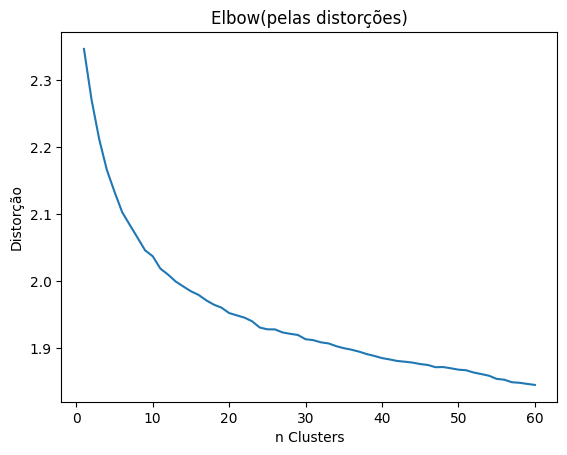


Número ideal de clusters :  13

 --------DESNORMALIZANDO DADOS--------


 -----------CENTROIDES DO CLUSTER------------------

          Ncodons         UUU         UUC         UUA         UUG         CUU  \
0    90753.041332   32.491797   34.177018  302.353426   30.029042   34.736844   
1     3569.952955  112.885461   50.138619   63.453983  307.290886   52.554000   
2   233585.021828  207.664426   34.548206   40.195692  353.534844  263.621732   
3   106722.799139   71.283052   28.343077  387.422377  199.646524  192.924296   
4    16030.942414   45.046293   76.988468   39.678437   49.736210   35.122931   
5    85105.949934  272.965149   44.224174  186.442091  213.255397  176.108959   
6     5401.410884   29.856665   32.352127   38.228644  261.723388   68.070369   
7    21532.995149   29.555898  116.476525   43.384866   92.722621  132.273746   
8   144394.436813   32.681538  273.183871   41.074461  166.209310   92.955397   
9   183745.732004   48.407647   52.955394  222.112733  107.5079

In [ ]:
trainer = Trainer()
trainer.train()

inferer = Inferer()
inferer.infer()
